## Probalistic Confirmed COVID19 Cases- Denmark

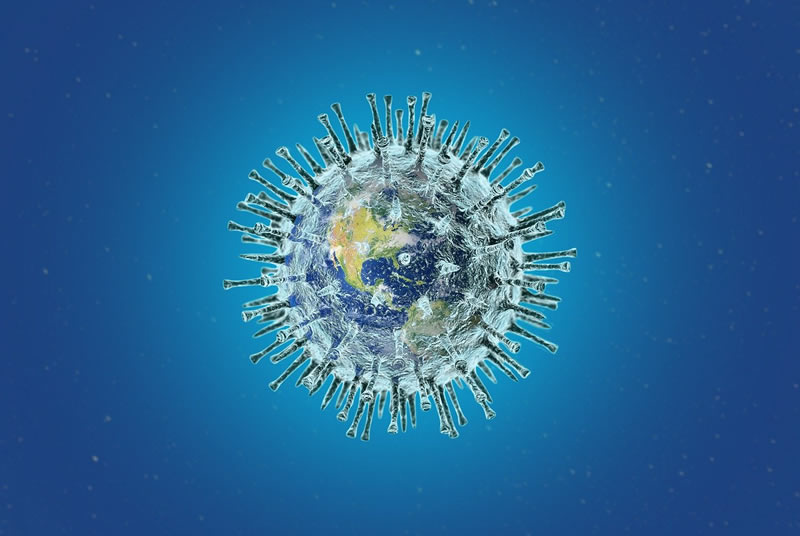

In [1]:
from os.path import join, pardir
ROOT = pardir
file = join(ROOT, "data", "raw", "covid19.jpg")
from IPython.display import Image
Image(filename=file)

### Table of contents
[Initialization](#Initialization)  
[Data Importing and Processing](#Data-Importing-and-Processing)
1. [Kalman Filter Modeling: Case of Denmark Data](#1.-Kalman-Filter-Modeling:-Case-of-Denmark-Data)  
    1.1. [Model with the vector c fixed as [0, 1]](#1.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    1.2. [Model with the vector c as a random variable with prior](#1.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    1.3. [Model without input (2 hidden variables)](#1.3.-Kalman-Filter-without-Input)  
2. [Kalman Filter Modeling: Case of Norway Data](#2.-Kalman-Filter-Modeling:-Case-of-Norway-Data)  
    2.1. [Model with the vector c fixed as [0, 1]](#2.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    2.2. [Model with the vector c as a random variable with prior](#2.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    2.3. [Model without input (2 hidden variables)](#2.3.-Kalman-Filter-without-Input)  
3. [Kalman Filter Modeling: Case of Sweden Data](#Kalman-Filter-Modeling:-Case-of-Sweden-Data)  
    3.1. [Model with the vector c fixed as [0, 1]](#3.1.-Kalman-Filter-Model-vector-c-fixed-as-[0,-1])  
    3.2. [Model with the vector c as a random variable with prior](#3.2.-Kalman-Filter-with-the-vector-c-as-a-random-variable-with-prior)  
    3.3. [Model without input (2 hidden variables)](#3.3.-Kalman-Filter-without-Input)  

## Initialization

In [7]:
from os.path import join, pardir

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns

from jax import lax, random, vmap
from jax.scipy.special import logsumexp
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler

np.random.seed(2103)

In [20]:
ROOT = pardir
DATA = join(ROOT, "data", "raw")

# random seed
np.random.seed(42)

#plot style
plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data Importing and Processing

The data in this case are the confirmed cases of the COVID-19 and the the mobility data (from Google) for three specific countries: Denmark, Sweden and Norway.


In [8]:
adress = join(ROOT, "data", "processed")
data = pd.read_csv(join(adress, 'data_five_mob_cov_daily.csv'),parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  462 non-null    datetime64[ns]
 1   Country               462 non-null    object        
 2   Confirmed             462 non-null    int64         
 3   daily_confirmed_case  462 non-null    int64         
 4   ret_rec_ch            462 non-null    int64         
 5   gr_ph_ch              459 non-null    float64       
 6   par_cha               462 non-null    int64         
 7   tra_sta_ch            462 non-null    int64         
 8   wor_ch                462 non-null    int64         
 9   res_ch                462 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 36.2+ KB


In [9]:
data.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,0,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,2,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,1,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,0,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,2,11,-5.0,28,1,2,0


Handy functions to split the data, train the models and plot the results.

In [5]:
def split_forecast(df, n_train=65):
    """Split dataframe `df` as training, test and input mobility data."""
    # just take the first 4 mobility features
    X = df.iloc[:, 4:8].values.astype(np.float_)
    # confirmed cases
    y = df.iloc[:, 3].values.astype(np.float_)

    idx_train = [*range(0,n_train)]
    idx_test = [*range(n_train, len(y))]

    y_train = y[:n_train]
    y_test = y[n_train:]

    return X, y_train, y_test


def train_kf(model, data, n_train, n_test, num_samples=12000, num_warmup=6000, **kwargs):
    """Train a Kalman Filter model."""
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    nuts_kernel = NUTS(model=model)
    # burn-in is still too much in comparison with the samples
    mcmc = MCMC(
        nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=1
    )
    mcmc.run(rng_key_, T=n_train, T_forecast=n_test, obs=data, **kwargs)
    return mcmc


def get_samples(mcmc):
    """Get samples from variables in MCMC."""
    return {k: v for k, v in mcmc.get_samples().items()}


def plot_samples(hmc_samples, nodes, dist=True):
    """Plot samples from the variables in `nodes`."""
    for node in nodes:
        if len(hmc_samples[node].shape) > 1:
            n_vars = hmc_samples[node].shape[1]
            for i in range(n_vars):
                plt.figure(figsize=(4, 3))
                if dist:
                    sns.distplot(hmc_samples[node][:, i], label=node + "%d" % i)
                else:
                    plt.plot(hmc_samples[node][:, i], label=node + "%d" % i)
                plt.legend()
                plt.show()
        else:
            plt.figure(figsize=(4, 3))
            if dist:
                sns.distplot(hmc_samples[node], label=node)
            else:
                plt.plot(hmc_samples[node], label=node)
            plt.legend()
            plt.show()

    
def plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test):
    """Plot the results of forecasting (dimension are different)."""
    y_hat = hmc_samples["y_pred"].mean(axis=0)
    y_std = hmc_samples["y_pred"].std(axis=0)
    y_pred_025 = y_hat - 1.96 * y_std
    y_pred_975 = y_hat + 1.96 * y_std
    plt.plot(idx_train, y_train, "b-")
    plt.plot(idx_test, y_test, "bx")
    plt.plot(idx_test[:-1], y_hat, "r-")
    plt.plot(idx_test[:-1], y_pred_025, "r--")
    plt.plot(idx_test[:-1], y_pred_975, "r--")
    plt.fill_between(idx_test[:-1], y_pred_025, y_pred_975, alpha=0.3)
    plt.legend(
        [
            "true (train)",
            "true (test)",
            "forecast",
            "forecast + stddev",
            "forecast - stddev",
        ]
    )
    plt.show()

n_train = 65  # number of points to train
n_test = 20   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

## 1. Kalman Filter Modeling: Case of Denmark Data

In [10]:
data_dk=data[data['Country'] == "Denmark"]
data_dk.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,0,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,2,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,1,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,0,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,2,11,-5.0,28,1,2,0


In [7]:
print("The length of the full dataset for Denmark is:" + " " )
print(len(data_dk))

The length of the full dataset for Denmark is: 
85


Prepare input of the models (we are using numpyro so the inputs are numpy arrays).

In [8]:
X, y_train, y_test = split_forecast(data_dk)

### 1.1. Kalman Filter Model vector c fixed as [0, 1]

First model: the sampling distribution is replaced by one fixed variable $c$.

In [9]:
def f(carry, input_t):
    x_t, noise_t = input_t
    W, beta, z_prev, tau = carry
    z_t = beta * z_prev + W @ x_t + noise_t
    z_prev = z_t
    return (W, beta, z_prev, tau), z_t


def model_wo_c(T, T_forecast, x, obs=None):
    """Define KF with inputs and fixed sampling dist."""
    # Define priors over beta, tau, sigma, z_1
    W = numpyro.sample(
        name="W", fn=dist.Normal(loc=jnp.zeros((2, 4)), scale=jnp.ones((2, 4)))
    )
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=0.1))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    obs_mean = z_collection[:T, 1]
    pred_mean = z_collection[T:, 1]

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [10]:
mcmc = train_kf(model_wo_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [10:23<00:00, 28.85it/s, 1023 steps of size 4.67e-05. acc. prob=0.88]


Plots of the distribution of the samples for each variable.

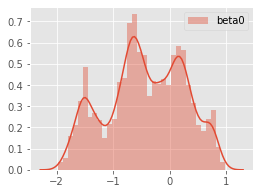

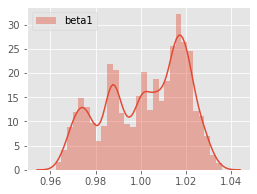

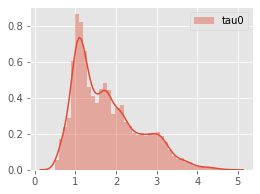

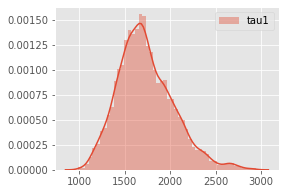

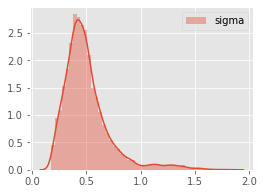

In [11]:
hmc_samples = get_samples(mcmc)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

Forecasting prediction, all the datapoints in the test set are within the Confidence Interval.

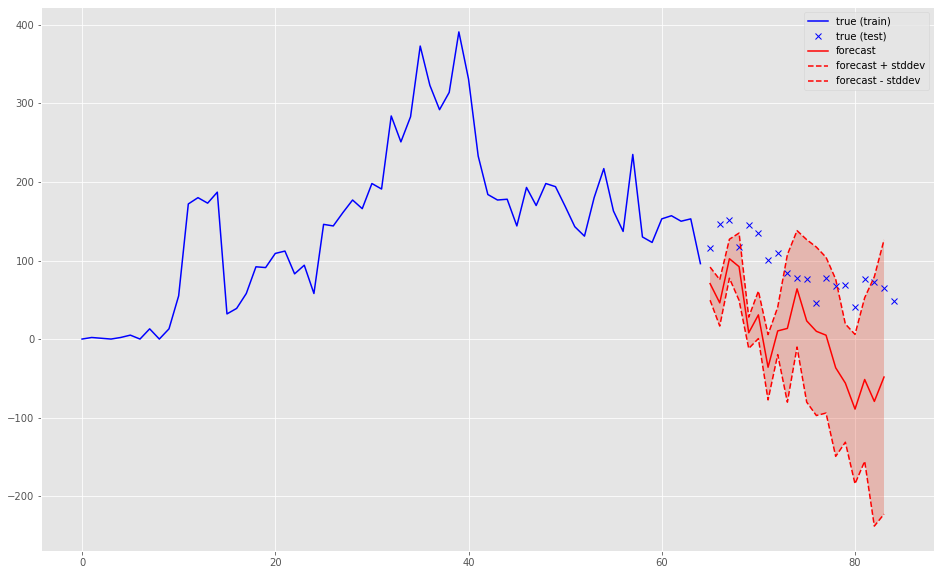

In [12]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 1.2. Kalman Filter with the vector c as a random variable with prior

Second model: the sampling distribution is a Normal distribution $c$.

In [13]:
def model_w_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(
        name="W", fn=dist.Normal(loc=jnp.zeros((2, 4)), scale=jnp.ones((2, 4)))
    )
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.array([0.0, 0.0]), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.array([2,2])))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(
        name="c", fn=dist.Normal(loc=jnp.array([[0.0], [0.0]]), scale=jnp.ones((2, 1)))
    )
    obs_mean = jnp.dot(z_collection[:T, :], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:, :], c).squeeze()

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [14]:
mcmc2 = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [09:34<00:00, 31.31it/s, 687 steps of size 7.51e-04. acc. prob=0.74] 


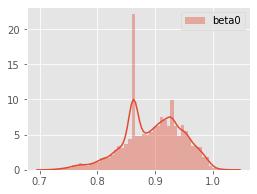

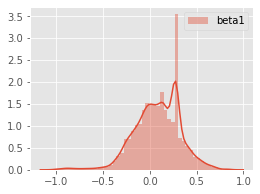

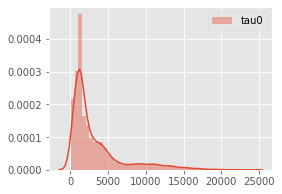

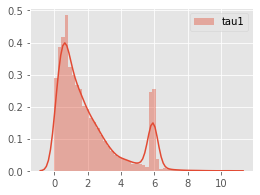

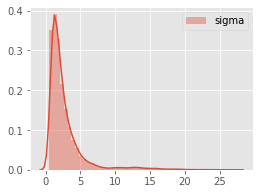

In [15]:
hmc_samples = get_samples(mcmc2)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

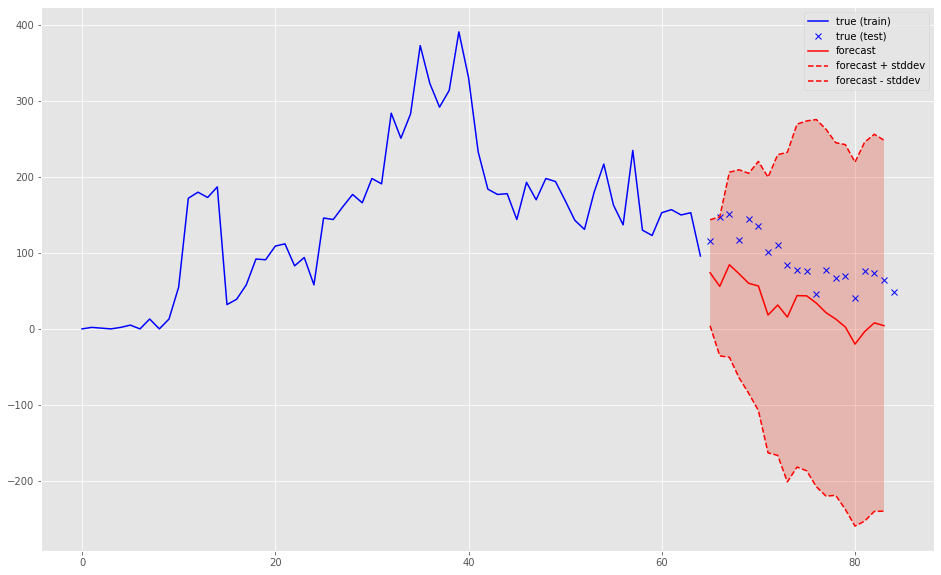

In [16]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 1.3. Kalman Filter without Input

Third model: no input mobility data, **two** hidden states.

In [17]:
def f_s(carry, noise_t):
    """Propagate forward the time series."""
    beta, z_prev, tau = carry
    z_t = beta * z_prev + noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def twoh_c_kf(T, T_forecast, obs=None):
    """Define Kalman Filter with two hidden variates."""
    # Define priors over beta, tau, sigma, z_1
    # W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.array([0.0, 0.0]), scale=jnp.ones(2))
    )
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.array([10,10])))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=5))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 2,),
    )
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f_s, carry, noises, T + T_forecast - 2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(
        name="c", fn=dist.Normal(loc=jnp.array([[0.0], [0.0]]), scale=jnp.ones((2, 1)))
    )
    obs_mean = jnp.dot(z_collection[:T, :], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:, :], c).squeeze()

    # Sample the observed y (y_obs)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [18]:
mcmc3 = train_kf(twoh_c_kf, y_train, n_train, n_test, num_samples=12000, num_warmup=5000)

sample: 100%|██████████| 17000/17000 [07:34<00:00, 37.44it/s, 1023 steps of size 1.10e-03. acc. prob=0.89] 


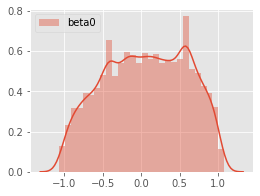

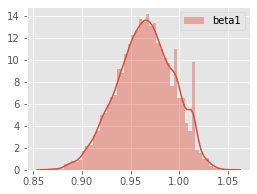

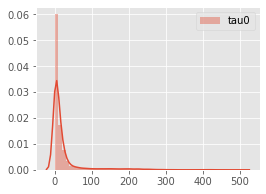

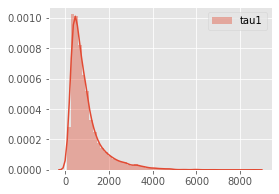

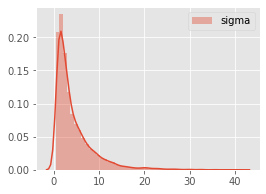

In [19]:
hmc_samples = get_samples(mcmc3)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

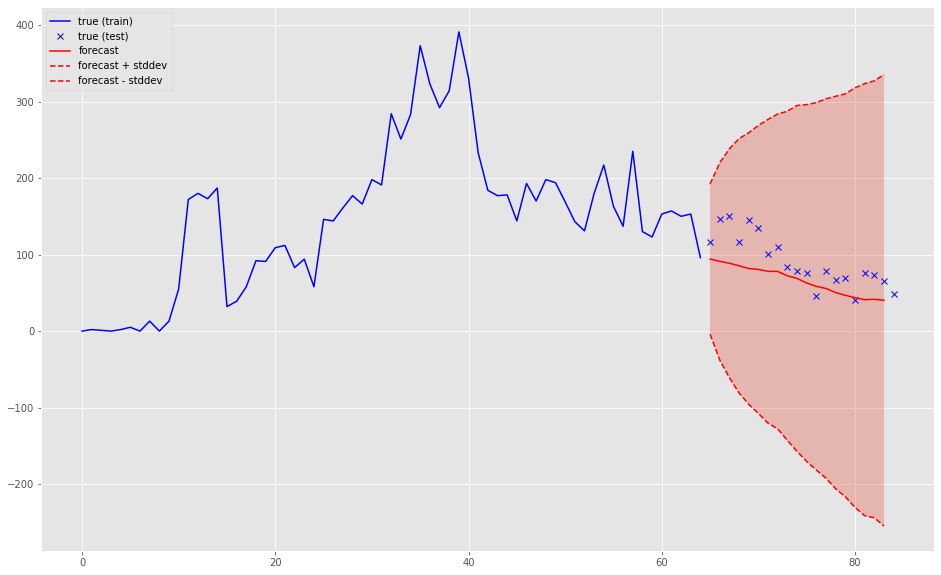

In [20]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## 2. Kalman Filter Modeling: Case of Germany Data

In [23]:
data_fi=data[data['Country'] == "Finland"]
data_fi.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
268,2020-02-15,Finland,1,0,3,0.0,-11,0,-2,0
269,2020-02-16,Finland,1,0,-3,-2.0,-24,-8,-3,1
270,2020-02-17,Finland,1,0,3,2.0,10,-10,-13,2
271,2020-02-18,Finland,1,0,2,2.0,22,-9,-13,2
272,2020-02-19,Finland,1,0,4,1.0,34,-8,-13,1


In [22]:
print("The length of the full dataset for Germany is:" + " " )
print(len(data_fi))

The length of the full dataset for Germany is: 
97


In [23]:
n_train = 75  # number of points to train
n_test = 22   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

In [24]:
X, y_train, y_test = split_forecast(data_fi, n_train)

### 2.1. Kalman Filter Model vector c fixed as [0, 1]

In [25]:
mcmc_fi = train_kf(model_wo_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [04:51<00:00, 61.81it/s, 127 steps of size 1.65e-02. acc. prob=0.79] 


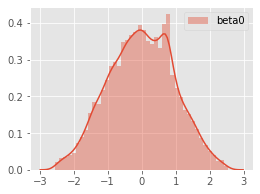

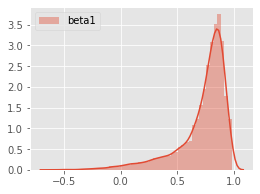

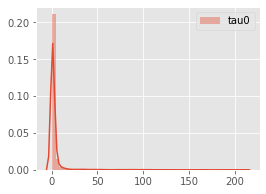

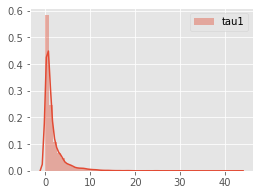

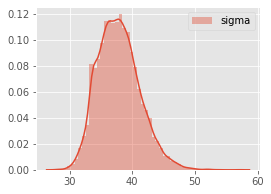

In [26]:
hmc_samples = get_samples(mcmc_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

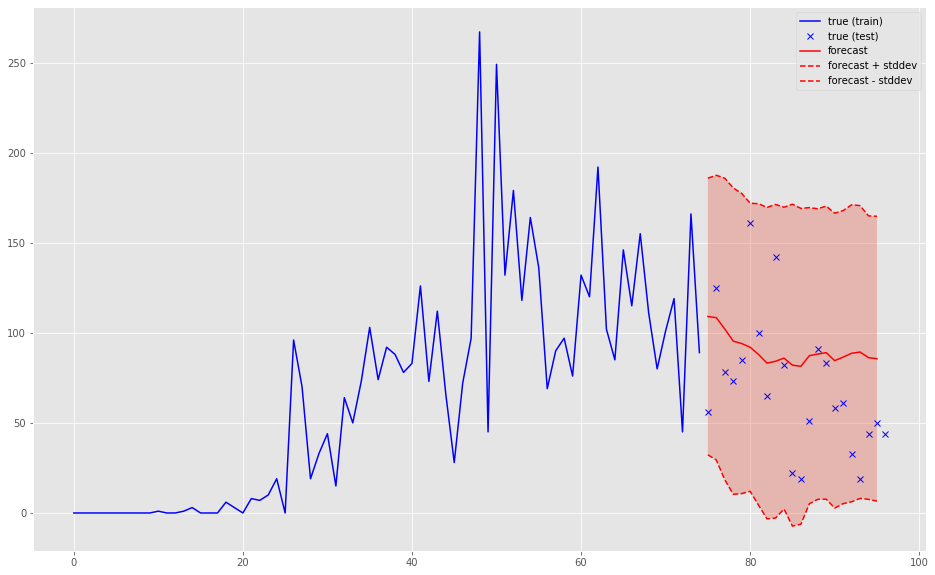

In [27]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 2.2. Kalman Filter with the vector c as a random variable with prior

In [28]:
mcmc2_fi = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [07:10<00:00, 41.86it/s, 481 steps of size 7.91e-03. acc. prob=0.78] 


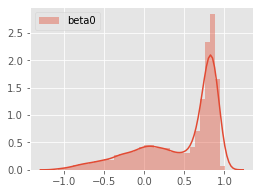

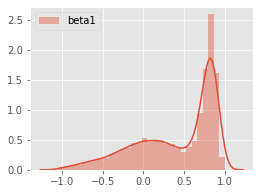

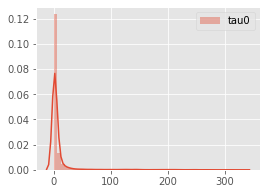

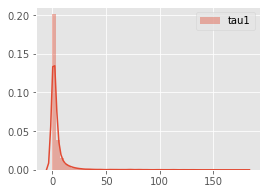

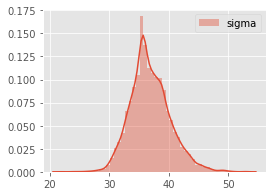

In [29]:
hmc_samples = get_samples(mcmc2_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

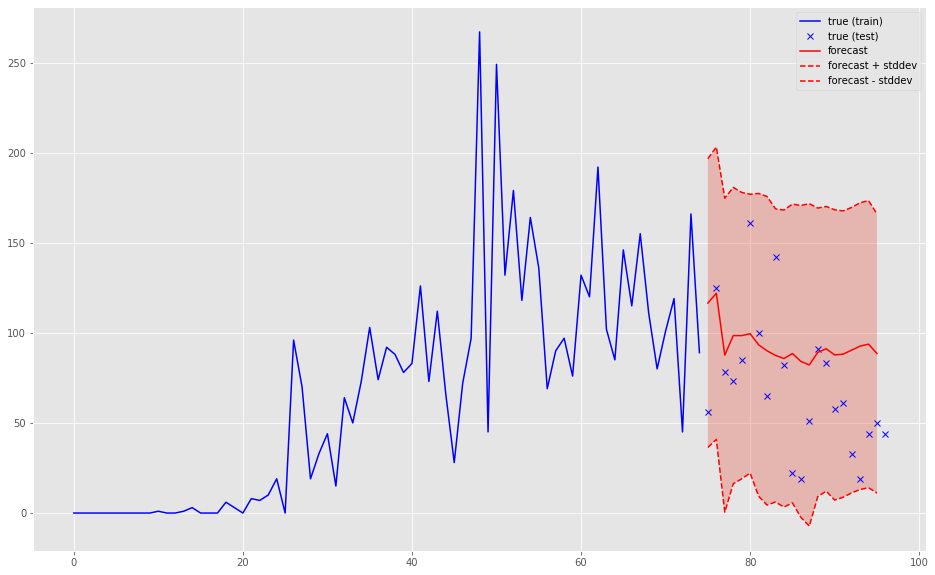

In [30]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 2.3. Kalman Filter without Input

In [31]:
mcmc3_fi = train_kf(twoh_c_kf, y_train, n_train, n_test)

sample: 100%|██████████| 18000/18000 [04:07<00:00, 72.79it/s, 255 steps of size 1.57e-02. acc. prob=0.74]  


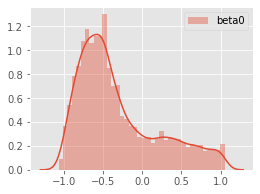

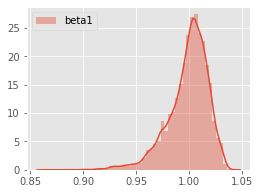

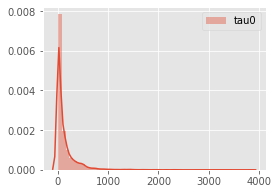

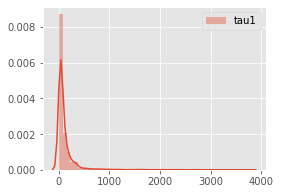

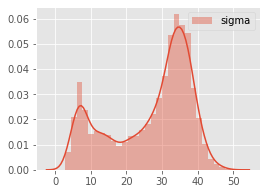

In [32]:
hmc_samples = get_samples(mcmc3_fi)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

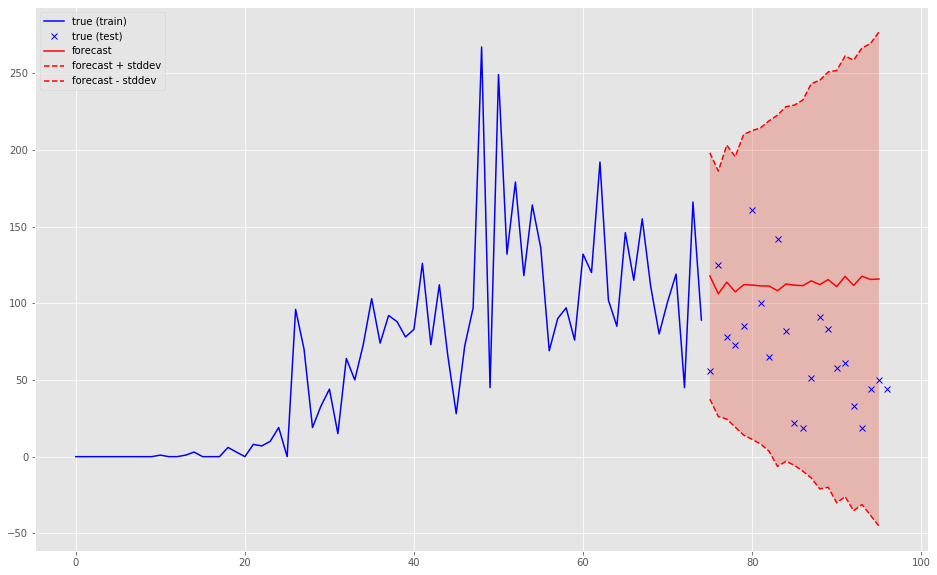

In [33]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

## 3. Kalman Filter Modeling: Case of Sweden Data

In [31]:
data_sw=data[data['Country'] == "Sweden"]
data_sw.head(5)

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
171,2020-02-15,Sweden,1,0,2,0.0,3,4,-2,0
172,2020-02-16,Sweden,1,0,-10,-7.0,-30,-11,-5,2
173,2020-02-17,Sweden,1,0,-4,-3.0,-3,-6,-6,2
174,2020-02-18,Sweden,1,0,0,0.0,13,-4,-5,1
175,2020-02-19,Sweden,1,0,3,1.0,26,-3,-5,1


In [35]:
print("The length of the full dataset for Sweden is:" + " " )
print(len(data_sw))

The length of the full dataset for Sweden is: 
97


In [36]:
n_train = 75  # number of points to train
n_test = 22   # number of points to forecast
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, n_train+n_test)]

In [37]:
X, y_train, y_test = split_forecast(data_sw, n_train)

### 3.1. Kalman Filter Model vector c fixed as [0, 1]

In [38]:
mcmc_sw = train_kf(model_wo_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [03:54<00:00, 76.84it/s, 127 steps of size 1.91e-02. acc. prob=0.96] 


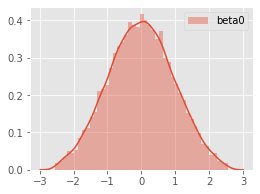

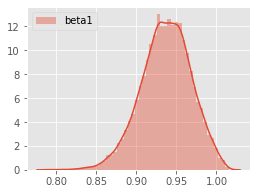

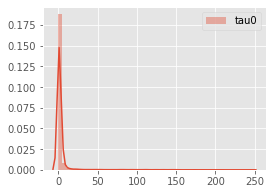

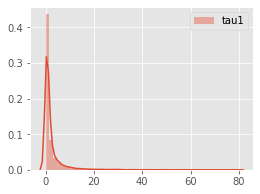

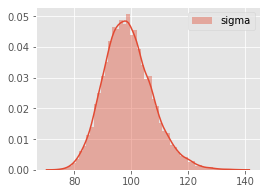

In [39]:
hmc_samples = get_samples(mcmc_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

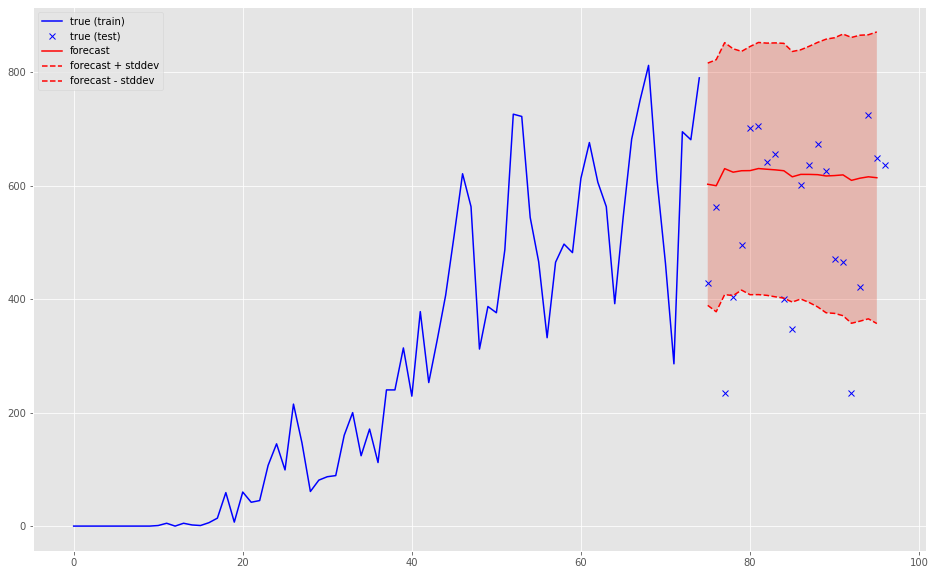

In [40]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 3.2. Kalman Filter with the vector c as a random variable with prior

In [41]:
mcmc2_sw = train_kf(model_w_c, y_train, n_train, n_test, x=X[:-2])

sample: 100%|██████████| 18000/18000 [09:05<00:00, 33.01it/s, 370 steps of size 6.72e-04. acc. prob=0.80] 


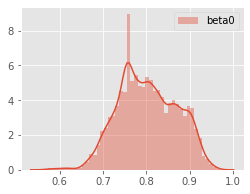

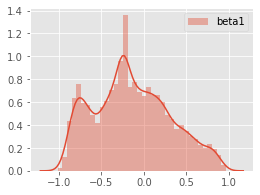

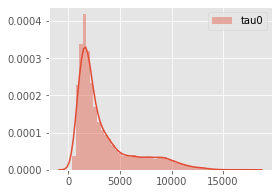

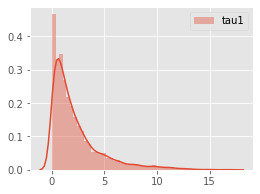

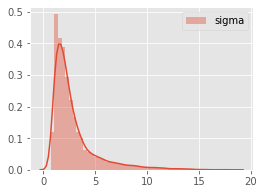

In [42]:
hmc_samples = get_samples(mcmc2_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

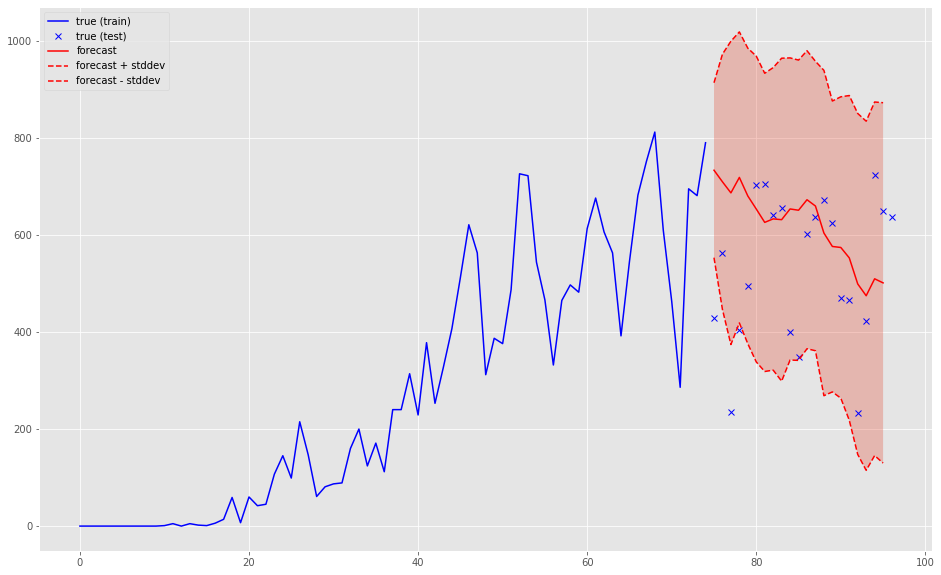

In [43]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

### 3.3. Kalman Filter without Input

In [44]:
mcmc3_sw = train_kf(twoh_c_kf, y_train, n_train, n_test)

sample: 100%|██████████| 18000/18000 [10:09<00:00, 29.51it/s, 710 steps of size 9.79e-04. acc. prob=0.82] 


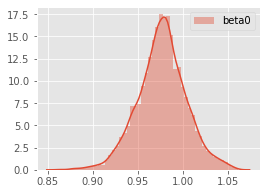

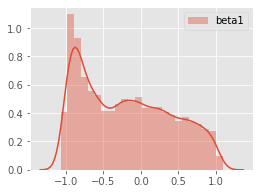

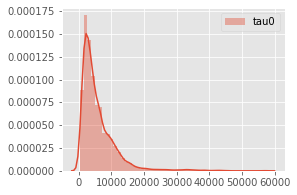

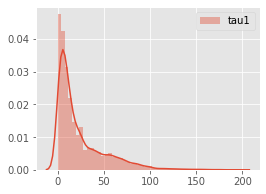

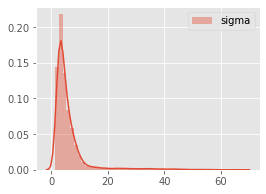

In [45]:
hmc_samples = get_samples(mcmc3_sw)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

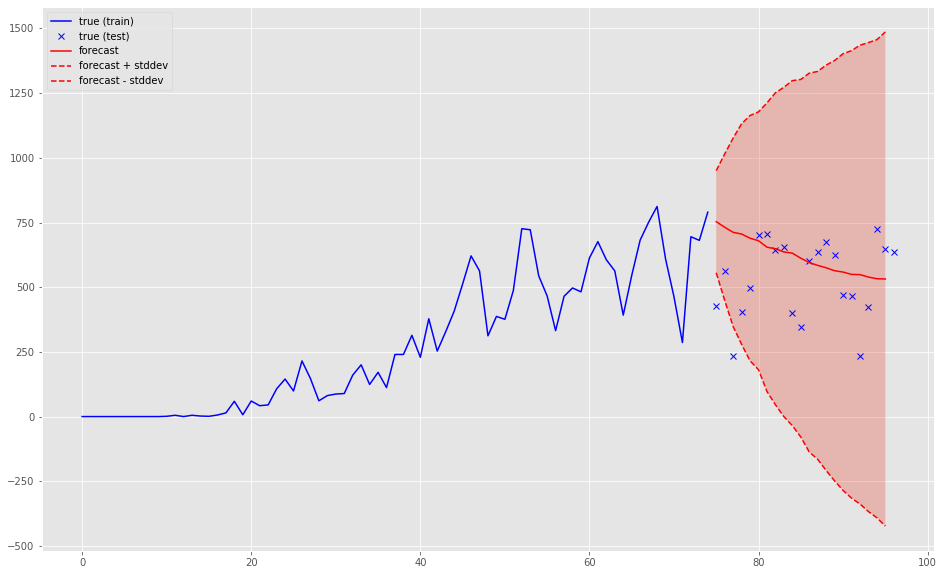

In [46]:
plot_forecast(hmc_samples, idx_train, idx_test, y_train, y_test)

Save results to rerun the plotting functions.

In [47]:
import pickle

In [48]:
MODELS = join(ROOT, "models")
for i, mc in enumerate([mcmc, mcmc2, mcmc3, 
                        mcmc_fi, mcmc2_fi, mcmc3_fi, 
                        mcmc_sw, mcmc2_sw, mcmc3_sw]):
    with open(join(MODELS, f"hmc_cummul_{i}.pickle"), "wb") as f:
        pickle.dump(get_samples(mc), f)

## Gaussian Process

In [15]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro 
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method

class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.
    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.X, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov

In [36]:
def plot(plot_observed_data=True, plot_predictions=False, plot_test_points=False,n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(16, 10))
    if plot_observed_data:
        plt.plot(X_train_tensor.view(-1,).numpy(), y_train_tensor.view(-1,).numpy(), 'kx')
    #if plot_test_points:
    #    plt.plot(x_test.T, y_test.T,'kx')
    if plot_predictions:
        Xtest = torch.linspace(0, 85, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest.double(), full_cov=True)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
        plt.plot(x_test.T, y_test.T,'kx',color='b')
        plt.legend(["Train Data","GP Posterior Mean", "Test Data"])
        plt.savefig("sweden_daily.png")
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(70, 85, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(0, 85)



### Gaussina Process: Case of Denamrk

In [11]:
x_train=data_dk.loc[:70,'Date'].index.values.reshape(-1,1).astype('float')
y_train=data_dk.loc[:70,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [12]:
x_test=data_dk.loc[71:85,'Date'].index.values.reshape(-1,1).astype('float')
y_test=data_dk.loc[71:85,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [13]:
X_train_tensor = torch.from_numpy(x_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)

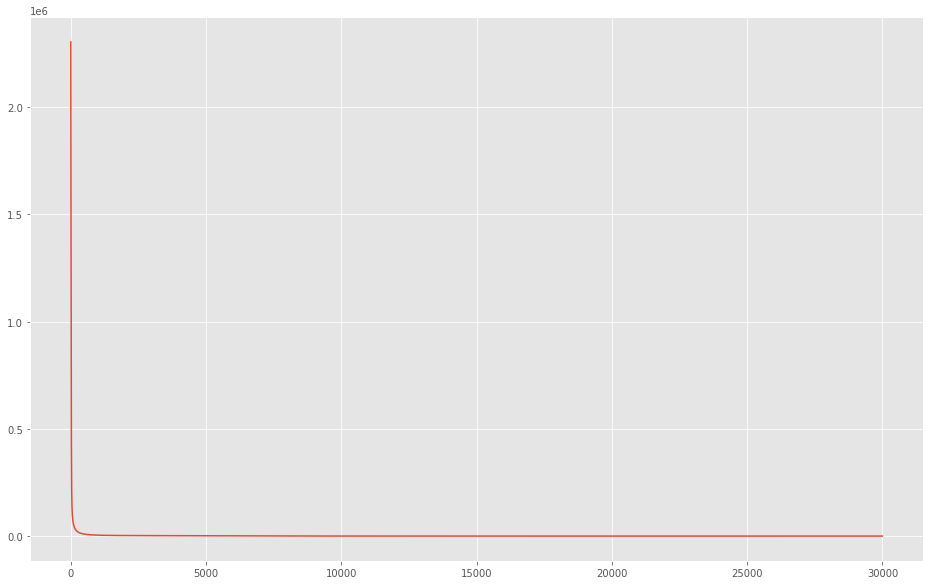

In [38]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 30000
losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

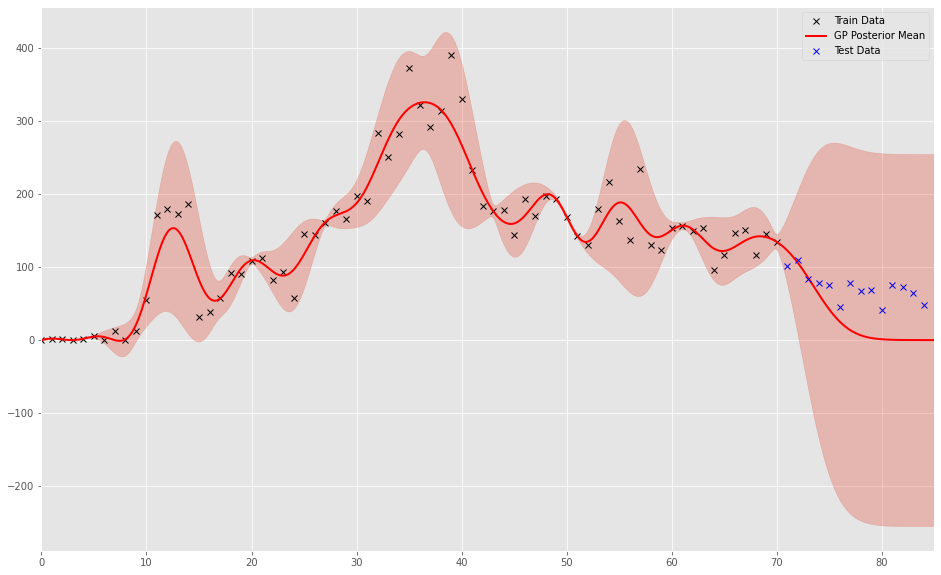

In [21]:
plot(model=vsgp, plot_observed_data=True,plot_predictions=True)

### Gaussian Process : Case of Finland

In [24]:
data_fi_res=data_fi.reset_index(drop=True)
x_train=data_fi_res.loc[:70,'Date'].index.values.reshape(-1,1).astype('float')
y_train=data_fi_res.loc[:70,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [25]:
x_test=data_fi_res.loc[71:85,'Date'].index.values.reshape(-1,1).astype('float')
y_test=data_fi_res.loc[71:85,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [26]:
X_train_tensor = torch.from_numpy(x_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)

In [27]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 30000
losses = gp.util.train(vsgp, num_steps=num_steps)

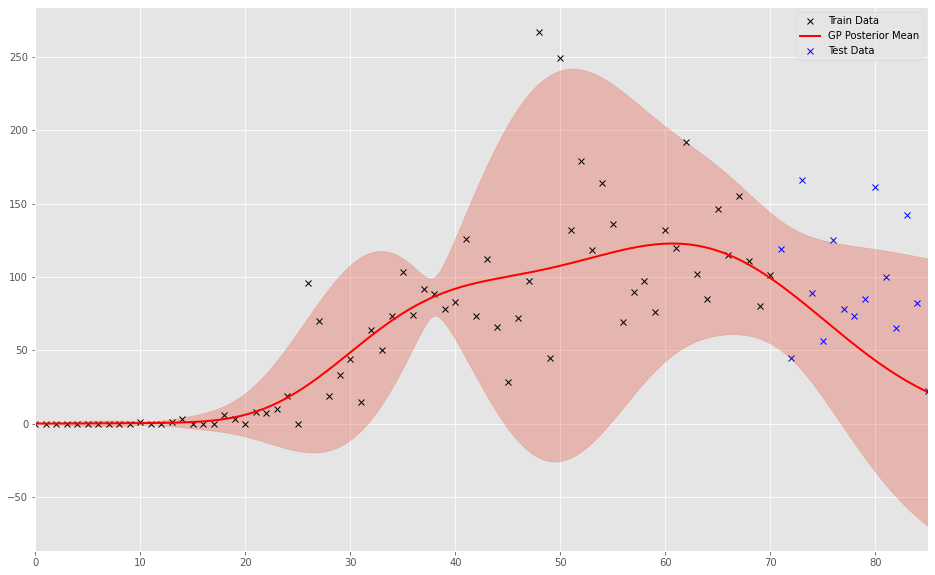

In [30]:
plot(model=vsgp, plot_observed_data=True,plot_predictions=True)

### Gaussian Process: Case of Sweden

In [32]:
data_sw_res=data_sw.reset_index(drop=True)
x_train=data_sw_res.loc[:70,'Date'].index.values.reshape(-1,1).astype('float')
y_train=data_sw_res.loc[:70,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [33]:
x_test=data_sw_res.loc[71:85,'Date'].index.values.reshape(-1,1).astype('float')
y_test=data_sw_res.loc[71:85,'daily_confirmed_case'].values.reshape(-1,1).astype('float')

In [34]:
X_train_tensor = torch.from_numpy(x_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)

In [35]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 30000
losses = gp.util.train(vsgp, num_steps=num_steps)

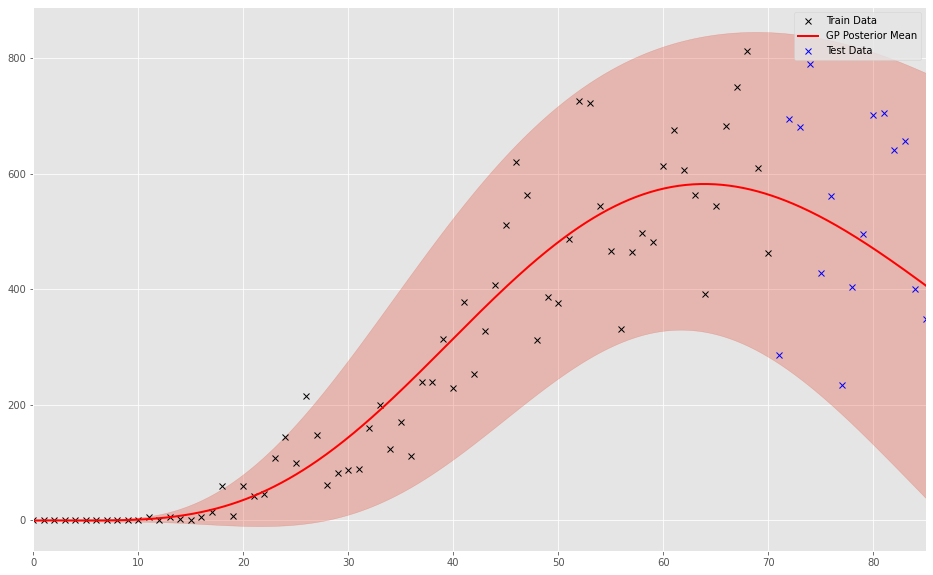

In [37]:
plot(model=vsgp, plot_observed_data=True,plot_predictions=True)